In [1]:
!pip install ndlinear

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns

## Loading Data

In [ ]:

data = pd.read_csv('insurance.csv')

X = data.drop('charges', axis=1)
y = data['charges']


numeric_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']


numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


X_processed = preprocessor.fit_transform(X)


In [ ]:
# Split the data into training and testing sets
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_np.values, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test_np.values, dtype=torch.float32).unsqueeze(1)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
from ndlinear import NdLinear  

class InsuranceModel(nn.Module):
    def __init__(self, input_dim):
        super(InsuranceModel, self).__init__()
        self.model = nn.Sequential(
            NdLinear(input_dims=(input_dim,), hidden_size=(64,)),
            nn.ReLU(),
            NdLinear(input_dims=(64,), hidden_size=(32,)),
            nn.ReLU(),
            NdLinear(input_dims=(32,), hidden_size=(1,))
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
# Initialize the model
input_dim = X_train_tensor.shape[1]
model = InsuranceModel(input_dim=input_dim)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch + 1}, Loss: {loss.item():.4f}')


Epoch 100, Loss: 10698881.0000
Epoch 200, Loss: 64340192.0000
Epoch 300, Loss: 42301548.0000
Epoch 400, Loss: 31465232.0000
Epoch 500, Loss: 22780794.0000


In [ ]:

model.eval()


with torch.no_grad():
    y_pred_list = []
    y_test_list = []
    for inputs, targets in test_loader:
        outputs = model(inputs)
        y_pred_list.append(outputs)
        y_test_list.append(targets)

    # Concatenate all batches
    y_pred = torch.cat(y_pred_list, dim=0)
    y_test = torch.cat(y_test_list, dim=0)


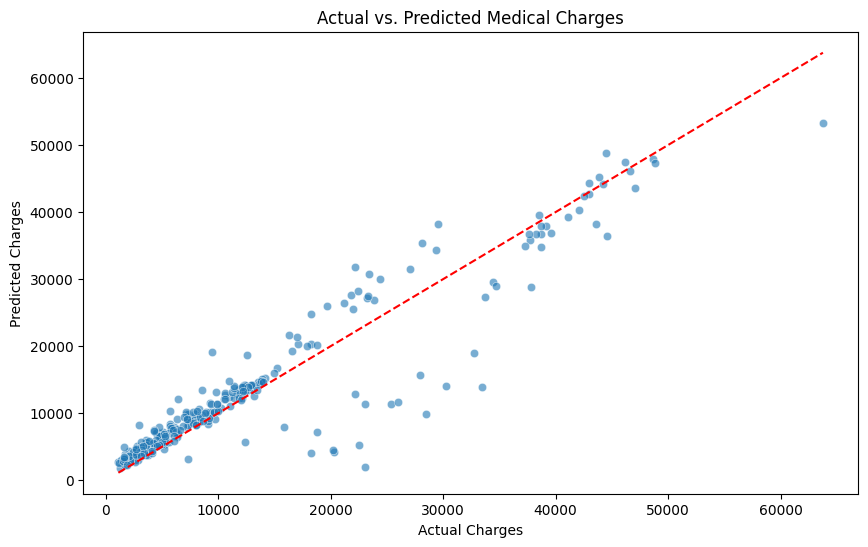

In [ ]:

y_test_np = y_test.numpy()
y_pred_np = y_pred.numpy()


plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_np.flatten(), y=y_pred_np.flatten(), alpha=0.6)
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs. Predicted Medical Charges')
plt.show()
